# Figures with Dynamics

This notebook is intended to provide figures relating to the *dynamics* of the models we are discussing. Figures related to *inference* are handled in separate notebooks for each data set. 

In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd

from matplotlib import pyplot as plt

from itertools import product

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

# Setup: 

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

# Read in pre-computed curves

The first thing we're going to do is read in and standardize the format of the equilibrium and stability curves we have pre-computed for this task. 

In [3]:
# SpringRank: prepared by Mari
df_SR = pd.read_csv('numerics/data_n_10.csv') # springRank
df_SR['s_1'] = df_SR.s1
df_SR['s_2'] = df_SR.s2
df_SR['n_1'] = df_SR.n1
df_SR['group'] = 1
df_SR = df_SR.drop(['s1', 's2', 'n2', 'n1'], axis = 1)
df_SR['stable'] = True

In [4]:
# need to pad this one from zero to 2

padding = pd.DataFrame(
    list(product(np.linspace(0,2, 21),
    [0], 
    [0], 
    [1], 
    [1], 
    [True])),
    columns = ['beta', 's_1', 's_2', 'n_1', 'group', 'stable']
)
df_SR = pd.concat((padding, df_SR), axis = 0)

In [5]:
df_deg = pd.read_csv('throughput/degree_score_curves.csv')
df_EV = pd.read_csv('throughput/eigenvector_score_curves.csv')

In [6]:
n = 10

def compute_gamma(row): 
    beta = row.beta
    s_1 = row.s_1
    s_2 = row.s_2
    n_1 = row.n_1
    n_2 = n - n_1
    
    v_1 = np.exp(beta*s_1)
    v_2 = np.exp(beta*s_2)
    
    gamma_1 = np.array(v_1/(n_1*v_1 + n_2*v_2))
    gamma_2 = np.array(v_2/(n_1*v_1 + n_2*v_2))
    
    return(pd.Series([gamma_1, gamma_2], index = ['gamma_1', 'gamma_2']))

In [7]:
df_SR = pd.concat((df_SR, df_SR.apply(compute_gamma, result_type = 'expand', axis = 1)), axis = 1)
df_deg = pd.concat((df_deg, df_deg.apply(compute_gamma, result_type = 'expand', axis = 1)), axis = 1)
df_EV = pd.concat((df_EV, df_EV.apply(compute_gamma, result_type = 'expand', axis = 1)), axis = 1)

In [8]:
# numerical issues on the degree score calculation
ix = df_deg.gamma_1 > .9
df_deg.stable[ix] = True

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
labels = ['SpringRank', 'Root-Degree', 'Eigenvector']
dfs = [df_SR, df_deg, df_EV]
instabilities = [2, 2*n**(1/2), n]
scores = [
    lambda A: homebrew_SpringRank_score(A.T),
    lambda A: powered_degree_score(A, .5),
    lambda A: eigenvector_score(A.T)
]

@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

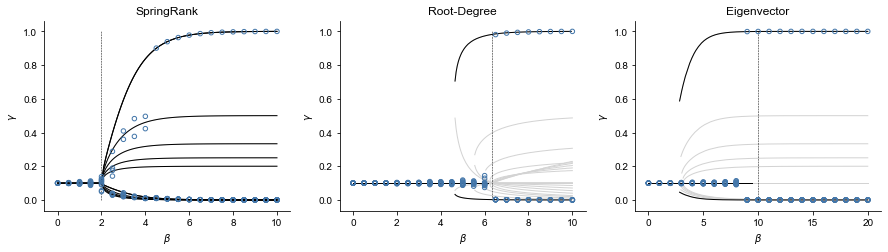

In [18]:
fig, axarr = plt.subplots(1,3, figsize = (15, 3.5))

b_grid = 21

BETA_VECS = [
    np.linspace(0, 10, b_grid),
    np.linspace(0, 10, b_grid),
    np.linspace(0, 20, b_grid)
]

lam = .9995
n_rounds = 50000

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

for i in range(3):
    ax = axarr[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set(xlabel = r'$\beta$')
    ax.set(ylabel = r'$\gamma$')
    
    df = dfs[i]
        
    p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_1, 
                                                                      zorder = 1,
                                                                      color = 'lightgrey', 
                                                                      linewidth = 1))
    
    p = df.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_2, 
                                                                      zorder = 1, 
                                                                      color = 'lightgrey', 
                                                                      linewidth = 1))
    
    df_sub = df[df.stable]
    
    p = df_sub.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_1, 
                                                                      zorder = 1, 
                                                                      color = 'black', 
                                                                      linewidth = 1))
    
    p = df_sub.groupby(['n_1','group', 'stable']).apply(lambda g: ax.plot(g.beta, g.gamma_2, 
                                                                      zorder = 1, 
                                                                      color = 'black', 
                                                                      linewidth = 1))
    
    ax.set(title = labels[i])
    ax.vlines(x = instabilities[i], ymin = 0, ymax = 1, linewidth = .5, linestyle = 'dashed')
    # fudge factor for numerical blips. Only add when we have rigorous proofs. 
    # ax.plot([0, instabilities[i]], [1/n, 1/n], zorder = 1, color = 'black', linewidth = 1) 
    
    BETAS = BETA_VECS[i]
    
    M = model()
    M.set_score(score_function = scores[i])
    M.set_features([linear_feature])
    
    V = np.zeros((b_grid, n))
    
    for j in range(b_grid):
        M.simulate(beta = np.array([BETAS[j]]), 
                           lam = lam, 
                           A0 = A0, 
                           n_rounds = n_rounds, 
                           update = stochastic_update, 
                           m_updates = 1)
        
        GAMMA = M.get_rates()
        GAMMA = np.sort(GAMMA, axis = 2)
        V[j] = GAMMA[(-5000):(-1)].mean(axis = (0,1))

    for k in range(V.shape[1]):
        p = ax.scatter(BETAS, V[:,k], alpha = 1, s=20, zorder = 2, facecolors='none', edgecolors = cset[0])

plt.savefig('fig/bifurcations_with_curves.png', dpi = 300, bbox_inches = 'tight')

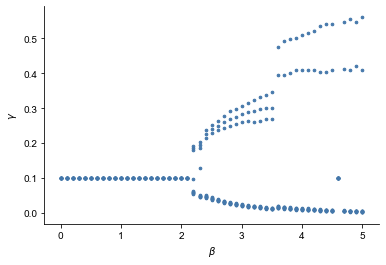

In [172]:
fig = plt.figure()
ax = fig.add_subplot()

# for n1 in np.arange(1,6):
#     sub = preds[preds.n1 == n1]
#     sub = sub[sub.beta <= 5]
#     v1 = sub.s1
#     v2 = sub.s2
#     n1 = sub.n1
#     n2 = sub.n2
#     v1 = np.exp(sub.beta*sub.s1)
#     v2 = np.exp(sub.beta*sub.s2)
#     gamma_1 = np.array(v1/(n1*v1 + n2*v2))
#     gamma_2 = np.array(v2/(n1*v1 + n2*v2))
#     ax.plot(sub.beta, gamma_1 , color = 'black', linewidth = .5)
#     ax.plot(sub.beta, gamma_2 , color = 'black', linewidth = .5)
#     ax.text(np.array(sub.beta).max()+.3, gamma_1[-1]-.01, s = r'$n_1 = $' + str(n1.max()))

# ax.plot([0,2], [.1,.1], color = 'black', linewidth = .5)    

n = 10

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

lam = .9
n_rounds = 5000

m_updates = 1

b_grid = 51

b_grid = 51
BETAS = np.linspace(0,5, b_grid)

V = np.zeros((b_grid, n))

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
M.set_features([linear_feature])

for j in range(b_grid):

    M.simulate(beta = np.array([BETAS[j]]), 
                       lam = lam, 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = deterministic_update, 
                       m_updates = m_updates)
    GAMMA = M.get_rates()
    GAMMA = np.sort(GAMMA, axis = 2)
    V[j] = GAMMA[(-1000):(-1)].mean(axis = (0,1))

for i in range(V.shape[1]):
    p = ax.scatter(BETAS, V[:,i], color = cset[0], alpha = 1, s=7)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set(xlabel = r'$\beta$')
ax.set(ylabel = r'$\gamma$')

plt.savefig('fig/springRank_with_curves.png', dpi = 300, bbox_inches = 'tight')

In [3]:
@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

# Detailed bifurcations: SpringRank

In [14]:
n = 5

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

lam = .9995
n_rounds = 50000

m_updates = 1

b_grid = 51
BETAS = np.linspace(1,3, b_grid)

V = np.zeros((b_grid, n))

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T), alpha = .00001)
M.set_features([linear_feature])

for j in range(b_grid):

    M.simulate(beta = np.array([BETAS[j]]), 
                       lam = lam, 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = stochastic_update, 
                       m_updates = m_updates)
    GAMMA = M.get_rates()
    GAMMA = np.sort(GAMMA, axis = 2)
    V[j] = GAMMA[(-5000):(-1)].mean(axis = (0,1))

[Text(0, 0.5, '$\\gamma$')]

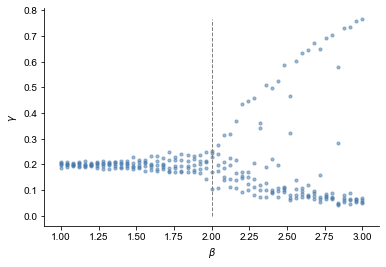

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(V.shape[1]):
    p = ax.scatter(BETAS, V[:,i], color = cset[0], alpha = 0.5, s=10)

ax.vlines(x = 2, ymin = 0, ymax = V.max(), linestyle = 'dashed', linewidth = 1, color = 'grey')    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set(xlabel = r'$\beta$')
ax.set(ylabel = r'$\gamma$')

# plt.savefig('fig/SR_bifurcation_detail.png', bbox_inches = 'tight')

# Comparison of Bifurcations with alternate score functions

In [160]:
# Params

A = np.sqrt(np.random.rand(n,n))
A0 = A/A.sum()
lam = .995

In [161]:
scores = {
    'SpringRank': lambda A: homebrew_SpringRank_score(A.T),
    'Root-Degree' : lambda A: powered_degree_score(A, 1/2), 
    'Fiedler Vector' : lambda A: -fiedler_vector_score(A)
}

transition_predictions = {
    'SpringRank': 2, 
    'Root-Degree': 2*n**(1/2),
    'Fiedler Vector': 0
}

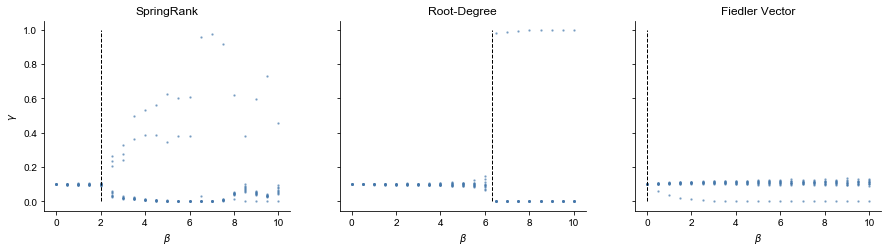

In [163]:
b_grid = 21
m_updates = 1
n_rounds = 50000

n = 10
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

BETAS = {
    'SpringRank' : np.linspace(0, 10, b_grid), 
    'Root-Degree': np.linspace(0,10, b_grid),
    'Fiedler Vector' : np.linspace(0,10,b_grid),
}

lam = .9995

score_names = ['SpringRank','Root-Degree', 'Fiedler Vector']

k = len(score_names)

fig, axarr = plt.subplots(1,k, figsize = (15, 3.5), sharey = True)

for i in range(k):
    
    M = model()
    M.set_score(score_function = scores[score_names[i]])
    M.set_features([linear_feature])
    
    V = np.zeros((b_grid, n))
    
    for j in range(b_grid):
        M.simulate(beta = np.array([BETAS[score_names[i]][j]]), 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = stochastic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        GAMMA = np.sort(GAMMA, axis = 2)
        V[j] = GAMMA[(-5000):(-1)].mean(axis = (0,1))
    
    if k == 1:
        ax = axarr
    else:
        ax = axarr[i]
    
    for j in range(V.shape[1]):
        p = ax.scatter(BETAS[score_names[i]], V[:,j], 
                       color = cset[0], alpha = 0.5, s=2)

#     p = ax.plot(BETAS[score_names[i]], V, color = 'grey', alpha = .5)
    
    v = ax.vlines(x = [transition_predictions[score_names[i]]], 
                        ymin = 0, 
                        ymax = 1, 
                        linewidth = 1, 
                        linestyle = 'dashed')
    
    t = ax.set_title(score_names[i])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set(xlabel = r'$\beta$')
    
    if i == 0:
        ax.set(ylabel = r'$\gamma$')
    
plt.savefig('fig/phase_transitions_stochastic.png', bbox_inches = 'tight', dpi = 300)

# Comparison: Impact of quadratic features

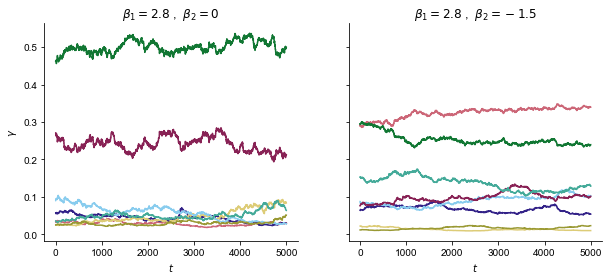

In [73]:
def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

lam = .998
n_rounds = 10000
m_updates = 1

n = 8
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()


fig, axarr = plt.subplots(1,2, figsize = (10, 4), sharey = True)

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
M.set_features([linear_feature, 
                quadratic_feature])

M.simulate(beta = np.array([2.8, 0]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()

for j in range(n):
    p = axarr[0].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])

M.simulate(beta = np.array([2.8, -1.5]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()
for j in range(n):
    p = axarr[1].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])


for ax in axarr:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel = r'$t$')
    
axarr[0].set(ylabel = r'$\gamma$')
axarr[0].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = 0$')
axarr[1].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = -1.5$')

plt.savefig('fig/SR_linear_and_quadratic.png', bbox_inches = 'tight', dpi = 300)